In [72]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import RMSprop, Adadelta, Adam

import numpy as np
import matplotlib.pyplot as plt
import sys
import pickle
import os

from utils_nlp import *
from memory_fusion_network import *
from sklearn.model_selection import train_test_split

np.random.seed(1337) 
tf.random.set_seed(1337)

In [73]:
def load_data(data_name):
    global output_dim

    pickle_data = '../input/cmu-mosi-explore/' + data_name + '.pkl'
    with open(pickle_data, 'rb') as fp:
        data = pickle.load(fp)

    X = [np.concatenate(tuple(data[typ][mod] for typ in ['train', 'valid', 'test']), axis=0) for mod in ['text', 'audio', 'vision']]
    y = np.squeeze(np.concatenate(tuple(data[typ]['labels'] for typ in ['train', 'valid', 'test']), axis=0))

    if len(y.shape) != 1:
        y = np.argmax(y, axis=1)
        
    mn, mx = np.min(y), np.max(y)
    shift = (mn + mx) / 2

    limit = 2
    roundoff = np.vectorize(lambda t : round_label(t, limit))

    y = roundoff(y - shift)
    
    X, y = remove_labels(X, y, [0])
    y = to_categorical(re_label(y))
    
    return X, y

In [74]:
data_name = 'mosei_20_seq_data'
data_name = 'iemocap_21_seq_data'
modals = {'T':[0], 'A':[1], 'V':[2],
          'TA':[0,1], 'TV':[0,2], 'AV':[1,2],
          'TAV':[0,1,2]}
data, labels = load_data(data_name)
print([t.shape for t in data])
print(labels.shape)

[(9848, 21, 300), (9848, 21, 74), (9848, 21, 35)]
(9848, 4)


In [192]:
mode = 'TV'
X = [data[i] for i in modals[mode]]
y = labels.astype(np.float64)

X_train, X_test = [], []
for modality in X:
    train, test = train_test_split(modality, test_size=0.2, shuffle=False)
    X_train.append(train)
    X_test.append(test)
    
y_train, y_test = train_test_split(y, test_size=0.2, shuffle=False)

In [193]:
K.clear_session()
mem_size = 512
input_shapes = [d.shape[1:] for d in X_train]
mfn = MFN(input_shapes, output_classes=y.shape[1], mem_size=mem_size)
# mfn.summary()

In [194]:
optimizer = Adam(lr=5e-4)
model_name = 'current_model.h5'
early_stopping = EarlyStopping(monitor='val_accuracy', patience=50, mode='max', verbose=1)
checkpointer = ModelCheckpoint(filepath=model_name, monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)
mfn.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [195]:
history = mfn.fit(X_train, y_train,
                  batch_size = 128 * 4,
                  epochs = 50,
                  shuffle = True,
                  validation_split = 0.15,
                  callbacks = [checkpointer, early_stopping])

Epoch 1/50
14/14 [==============================] - ETA: 0s - loss: 3.9527 - accuracy: 0.4577
Epoch 00001: val_accuracy improved from -inf to 0.49492, saving model to current_model.h5
14/14 [==============================] - 3s 221ms/step - loss: 3.9527 - accuracy: 0.4577 - val_loss: 3.5021 - val_accuracy: 0.4949
Epoch 2/50
14/14 [==============================] - ETA: 0s - loss: 3.3163 - accuracy: 0.4703
Epoch 00002: val_accuracy improved from 0.49492 to 0.50761, saving model to current_model.h5
14/14 [==============================] - 2s 168ms/step - loss: 3.3163 - accuracy: 0.4703 - val_loss: 2.9885 - val_accuracy: 0.5076
Epoch 3/50
14/14 [==============================] - ETA: 0s - loss: 2.8444 - accuracy: 0.4713
Epoch 00003: val_accuracy improved from 0.50761 to 0.51438, saving model to current_model.h5
14/14 [==============================] - 3s 193ms/step - loss: 2.8444 - accuracy: 0.4713 - val_loss: 2.5539 - val_accuracy: 0.5144
Epoch 4/50
14/14 [==============================]

Epoch 29/50
14/14 [==============================] - ETA: 0s - loss: 1.1880 - accuracy: 0.5411
Epoch 00029: val_accuracy did not improve from 0.54822
14/14 [==============================] - 2s 170ms/step - loss: 1.1880 - accuracy: 0.5411 - val_loss: 1.2235 - val_accuracy: 0.5254
Epoch 30/50
14/14 [==============================] - ETA: 0s - loss: 1.1705 - accuracy: 0.5415
Epoch 00030: val_accuracy did not improve from 0.54822
14/14 [==============================] - 2s 155ms/step - loss: 1.1705 - accuracy: 0.5415 - val_loss: 1.2011 - val_accuracy: 0.5474
Epoch 31/50
14/14 [==============================] - ETA: 0s - loss: 1.1666 - accuracy: 0.5429
Epoch 00031: val_accuracy did not improve from 0.54822
14/14 [==============================] - 2s 152ms/step - loss: 1.1666 - accuracy: 0.5429 - val_loss: 1.2736 - val_accuracy: 0.4983
Epoch 32/50
14/14 [==============================] - ETA: 0s - loss: 1.1719 - accuracy: 0.5526
Epoch 00032: val_accuracy improved from 0.54822 to 0.54907, sa

In [200]:
classes = sorted(list(set(sorted(list(np.argmax(y_train, axis=1))))))
filename = '_'.join([data_name.replace('_data', ''), mode, str(len(classes))+'way', f'memsz{mem_size}'])
print(filename)
preds = mfn.predict(X_test)
calc_test_result(preds, y_test)
print('-' * 60)

iemocap_21_seq_TV_4way_memsz512
Confusion Matrix :
[[0.3  0.02 0.14 0.54]
 [0.04 0.31 0.09 0.56]
 [0.06 0.07 0.35 0.52]
 [0.1  0.06 0.09 0.75]]
Classification Report :
              precision    recall  f1-score   support
           0     0.4718    0.2992    0.3662       391
           1     0.4724    0.3143    0.3775       245
           2     0.4007    0.3520    0.3748       321
           3     0.5967    0.7522    0.6655      1013
    accuracy                         0.5426      1970
   macro avg     0.4854    0.4294    0.4460      1970
weighted avg     0.5245    0.5426    0.5229      1970
------------------------------------------------------------


<Figure size 432x288 with 0 Axes>

<Figure size 1584x864 with 0 Axes>

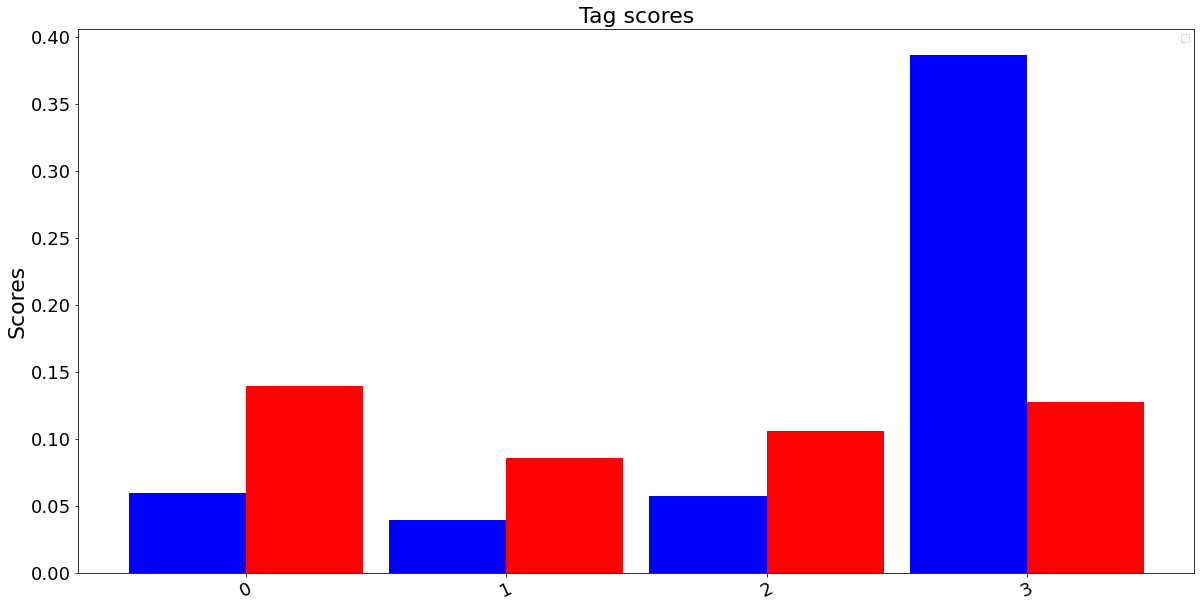

<Figure size 432x288 with 0 Axes>

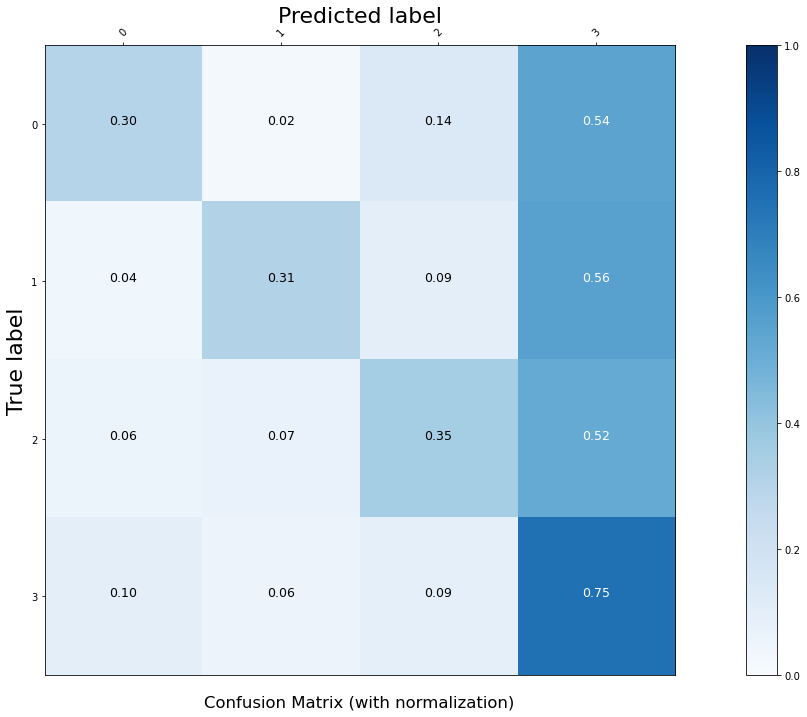

In [201]:
y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(preds, axis=1)
class_names, report, support = get_report(y_true, y_pred, classes)
cm = confusion_matrix(y_true, y_pred, labels=classes)
scores = get_scores(y_true, y_pred, classes)

plot_clf_report(class_names, report, support, filename=filename+'_clf_report')
plot_tag_scores(classes, scores, filename=filename+'_tag_scores')
plot_confusion_matrix(classes, cm, filename=filename+'_cm')

In [199]:
if os.path.isfile(model_name):
    mfn.load_weights(model_name)
    print('Loaded saved Model!')

Loaded saved Model!


In [202]:
!zip -r results.zip *.png

updating: iemocap_21_seq_TAV_4way_memsz128_clf_report.png (deflated 13%)
updating: iemocap_21_seq_TAV_4way_memsz128_cm.png (deflated 12%)
updating: iemocap_21_seq_TAV_4way_memsz128_tag_scores.png (deflated 25%)
updating: iemocap_21_seq_TAV_4way_memsz256_clf_report.png (deflated 15%)
updating: iemocap_21_seq_TAV_4way_memsz256_cm.png (deflated 14%)
updating: iemocap_21_seq_TAV_4way_memsz256_tag_scores.png (deflated 24%)
updating: iemocap_21_seq_TAV_4way_memsz512_clf_report.png (deflated 14%)
updating: iemocap_21_seq_TAV_4way_memsz512_cm.png (deflated 12%)
updating: iemocap_21_seq_TAV_4way_memsz512_tag_scores.png (deflated 25%)
updating: iemocap_21_seq_TA_4way_memsz128_clf_report.png (deflated 14%)
updating: iemocap_21_seq_TA_4way_memsz128_cm.png (deflated 12%)
updating: iemocap_21_seq_TA_4way_memsz128_tag_scores.png (deflated 24%)
updating: iemocap_21_seq_TA_4way_memsz256_clf_report.png (deflated 16%)
updating: iemocap_21_seq_TA_4way_memsz256_cm.png (deflated 12%)
updating: iemocap_21_se

In [ ]:
!rm -rf *.png